In [ ]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import glob
import pydicom
import os

# 이미지 파일이 모여있는 폴더 경로
image_folder_path = "/content/drive/MyDrive/images"

# 폴더 내의 이미지 파일 목록 얻기
image_files = glob.glob(os.path.join(image_folder_path, "*.dcm"))

# 이미지 파일을 읽어오고 리스트에 저장
images = []
for file_path in image_files:
    image = pydicom.dcmread(file_path)
    images.append(image)

# 이미지 파일의 개수와 예시 이미지 확인
print("image_num:", len(images))
print("sample:", images[0])  # 첫 번째 이미지 출력



image_num: 1436
sample: Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.5913.1517874318.995539
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.5913.1517874318.995539
(0008, 0020) Study Date                          DA: '19010101'
(0008, 

In [ ]:
import pandas as pd

# 훈련 데이터 로드
train_labels = pd.read_csv("/content/drive/MyDrive/stage_2_train_labels/stage_2_train_labels.csv")

# 클래스 분포 확인
class_counts = train_labels["Target"].value_counts()
print(class_counts)


0    20672
1     9555
Name: Target, dtype: int64


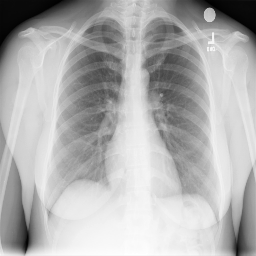

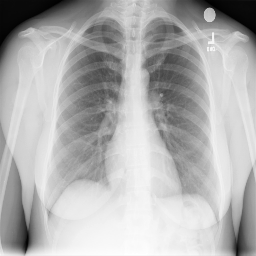

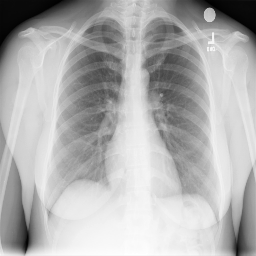

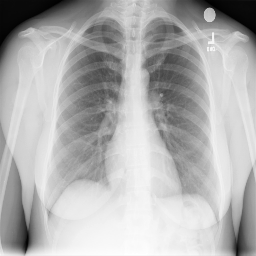

In [ ]:
from google.colab.patches import cv2_imshow
import pydicom
import cv2
import numpy as np

def preprocess_image(image, target_size):
    # 이미지 resize
    image = cv2.resize(image.pixel_array, target_size)

    # 이미지 정규화
    image = (image - np.min(image)) / (np.max(image) - np.min(image))

    return image

# 전처리를 위한 target 이미지 크기
target_size = (256, 256)

preprocessed_images = []
for file_path in image_files:
    image = pydicom.dcmread(file_path)
    preprocessed_image = preprocess_image(image, target_size)
    preprocessed_images.append(preprocessed_image)

# 전처리된 이미지 확인
for i in range(4):
    cv2_imshow((preprocessed_image * 255).astype(np.uint8))


In [ ]:
class_info= pd.read_csv('/content/drive/MyDrive/stage_2_detailed_class_info.csv')

# train 데이터와 class 정보 merge
merged_data = pd.merge(train_labels, class_info, on="patientId")

In [ ]:
class_count = len(merged_data["class"].unique())
print("class_num:", class_count)
class_list = merged_data["class"].unique()
print("class_list:", class_list)


class_num: 3
class_list: ['No Lung Opacity / Not Normal' 'Normal' 'Lung Opacity']


In [ ]:
# class 별로 이미지 저장할 dictionary 생성
class_images = {class_label: [] for class_label in class_list}

# 이미지 전처리 후 class 별로 저장
for file_path in image_files:
    image = pydicom.dcmread(file_path)
    preprocessed_image = preprocess_image(image, target_size)

    patient_id = os.path.splitext(os.path.basename(file_path))[0]
    class_label = merged_data.loc[merged_data["patientId"] == patient_id, "class"].values[0]

    class_images[class_label].append(preprocessed_image)

# 클래스 별로 이미지 저장된 리스트들을 numpy array로 변환
for class_label in class_images:
    class_images[class_label] = np.array(class_images[class_label])

In [ ]:
from sklearn.model_selection import train_test_split

# dataset 분할
train_data = []
train_labels = []
val_data = []
val_labels = []
test_data = []
test_labels = []

for class_label in class_images:
    images = class_images[class_label]
    labels = np.full(len(images), class_label)

    X_trainval, X_test, y_trainval, y_test = train_test_split(
        images, labels, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=0.25, random_state=42)

    train_data.extend(X_train)
    train_labels.extend(y_train)
    val_data.extend(X_val)
    val_labels.extend(y_val)
    test_data.extend(X_test)
    test_labels.extend(y_test)

In [ ]:
# 전처리된 이미지와 레이블을 numpy array로 변환
train_data = np.array(train_data)
train_labels = np.array(train_labels)
val_data = np.array(val_data)
val_labels = np.array(val_labels)
test_data = np.array(test_data)
test_labels = np.array(test_labels)

# 데이터셋 크기 확인
print("Train dataset size:", train_data.shape)
print("Validation dataset size:", val_data.shape)
print("Test dataset size:", test_data.shape)

Train dataset size: (860, 256, 256)
Validation dataset size: (288, 256, 256)
Test dataset size: (288, 256, 256)


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np

# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(class_count, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
# Convert grayscale images to RGB
train_data_rgb = np.repeat(train_data[..., np.newaxis], 3, axis=-1)
val_data_rgb = np.repeat(val_data[..., np.newaxis], 3, axis=-1)
test_data_rgb = np.repeat(test_data[..., np.newaxis], 3, axis=-1)


In [ ]:
print(train_data_rgb.dtype)
print(train_labels.dtype)
print(val_data_rgb.dtype)
print(val_labels.dtype)


float64
<U28
float64
<U28


In [ ]:
# label 데이터를 숫자로 변환
label_mapping = {"Normal": 0, "Lung Opacity": 1, "No Lung Opacity / Not Normal": 2}
train_labels = np.array([label_mapping[label] for label in train_labels])
val_labels = np.array([label_mapping[label] for label in val_labels])

Epoch 1/20
27/27 [==============================] - 30s 487ms/step - loss: 1.0629 - accuracy: 0.4267 - val_loss: 1.0383 - val_accuracy: 0.5590
Epoch 2/20
27/27 [==============================] - 6s 217ms/step - loss: 0.9830 - accuracy: 0.5105 - val_loss: 0.9583 - val_accuracy: 0.5417
Epoch 3/20
27/27 [==============================] - 6s 218ms/step - loss: 0.9303 - accuracy: 0.5140 - val_loss: 0.9368 - val_accuracy: 0.5660
Epoch 4/20
27/27 [==============================] - 6s 219ms/step - loss: 0.8905 - accuracy: 0.5663 - val_loss: 0.9204 - val_accuracy: 0.5938
Epoch 5/20
27/27 [==============================] - 6s 222ms/step - loss: 0.8538 - accuracy: 0.5919 - val_loss: 0.9047 - val_accuracy: 0.5660
Epoch 6/20
27/27 [==============================] - 6s 223ms/step - loss: 0.8416 - accuracy: 0.6000 - val_loss: 0.9052 - val_accuracy: 0.5486
Epoch 7/20
27/27 [==============================] - 6s 226ms/step - loss: 0.8233 - accuracy: 0.6128 - val_loss: 0.9022 - val_accuracy: 0.5903
Epoch

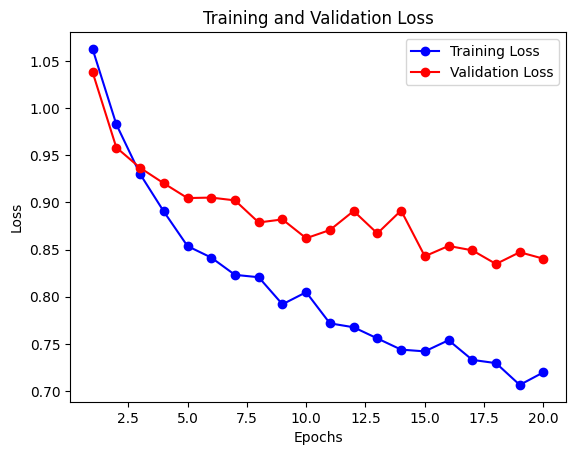

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data_rgb, train_labels, epochs=20, validation_data=(val_data_rgb, val_labels))

import matplotlib.pyplot as plt

# loss 추이 시각화
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
loss, accuracy = model.evaluate(val_data_rgb, val_labels)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

9/9 [==============================] - 2s 171ms/step - loss: 0.8404 - accuracy: 0.5799
Validation Loss: 0.8403655290603638
Validation Accuracy: 0.5798611044883728


In [ ]:
predictions = model.predict(test_data_rgb)

9/9 [==============================] - 2s 164ms/step


In [ ]:
predicted_labels = np.argmax(predictions, axis=1)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score

accuracy = accuracy_score(val_labels, predicted_labels)
precision = precision_score(val_labels, predicted_labels, average='weighted')
recall = recall_score(val_labels, predicted_labels, average='weighted')
f1 = f1_score(val_labels, predicted_labels, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.6006944444444444
Precision: 0.6133271455835868
Recall: 0.6006944444444444
F1-score: 0.6044954734550319


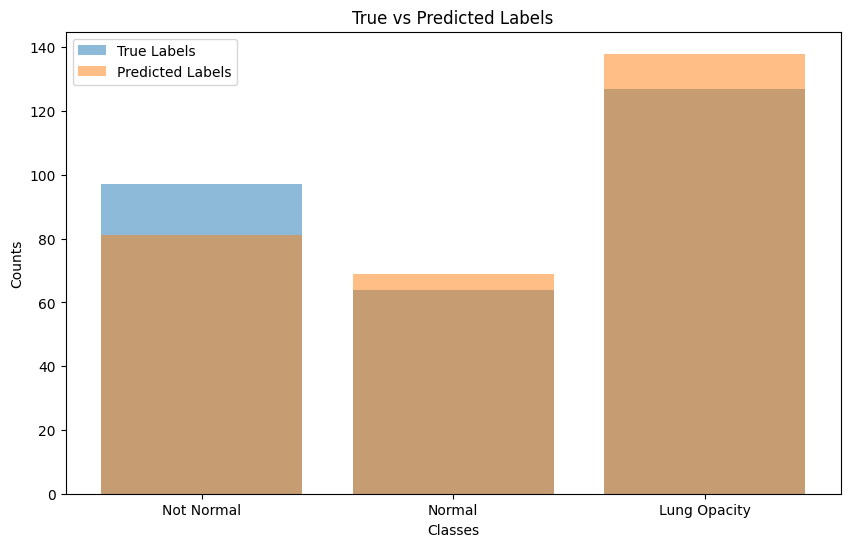

In [ ]:
import matplotlib.pyplot as plt

def plot_predictions(true_labels, predicted_labels):
    classes = ['Not Normal', 'Normal', 'Lung Opacity']  # Modify the class labels according to your problem
    num_classes = len(classes)

    # Count the number of true and predicted labels for each class
    true_class_counts = [np.sum(true_labels == i) for i in range(num_classes)]
    pred_class_counts = [np.sum(predicted_labels == i) for i in range(num_classes)]

    # Bar plot visualization
    plt.figure(figsize=(10, 6))
    plt.bar(classes, true_class_counts, alpha=0.5, label='True Labels')
    plt.bar(classes, pred_class_counts, alpha=0.5, label='Predicted Labels')
    plt.xlabel('Classes')
    plt.ylabel('Counts')
    plt.title('True vs Predicted Labels')
    plt.legend()
    plt.show()

plot_predictions(val_labels, predicted_labels)



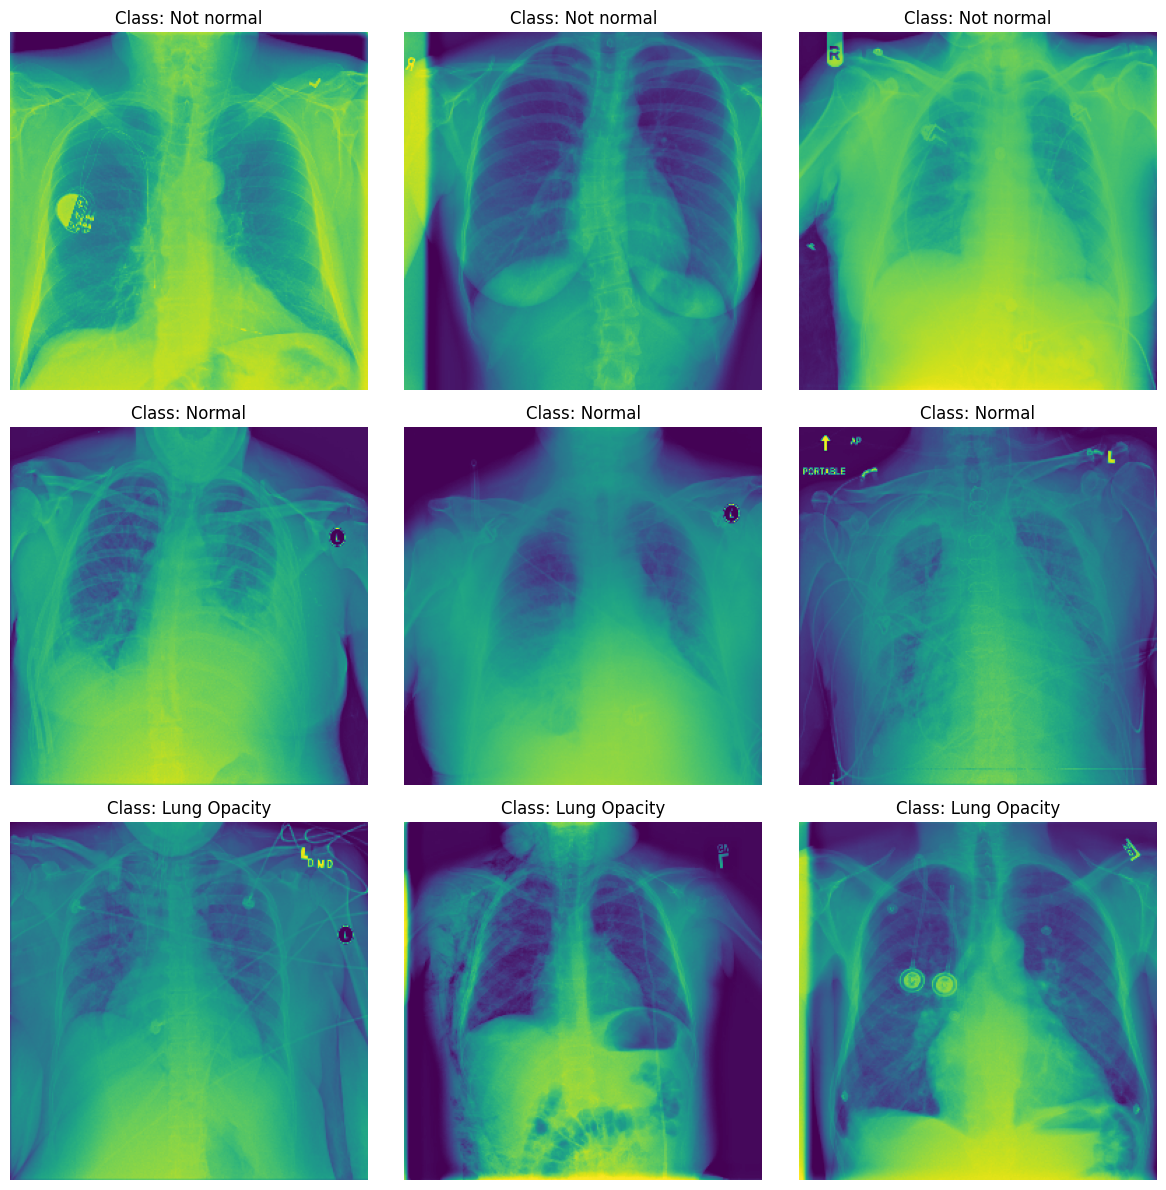

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

def plot_images_by_class(images, labels, classes, num_images=3, rows=3, cols=3):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    axes = axes.flatten()

    for i, cls in enumerate(classes):
        cls_indices = np.where(labels == i)[0]
        selected_indices = np.random.choice(cls_indices, num_images, replace=False)

        for j, idx in enumerate(selected_indices):
            img = images[idx]
            ax = axes[i * cols + j]
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(f'Class: {cls}')

    plt.tight_layout()
    plt.show()

# train_data 변수에 이미지 데이터를 저장한 후 실행
plot_images_by_class(train_data, train_labels, classes=['Not normal', 'Normal', 'Lung Opacity'])


In [ ]:
!jupyter nbconvert --to html ""